In [9]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import catboost as cb
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
import optuna
from optuna.samplers import TPESampler
import re
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import gensim
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.word2vec import Word2Vec
from sklearn.decomposition import PCA
import gc


warnings.simplefilter('ignore')

In [11]:
# import pandas as pd
# # Make dataset based on Josh Starmer video example
# # https://www.youtube.com/watch?v=EzjtTh-WUWY

# categorical = ["Blue","Red","Green","Blue","Green","Green","Blue"] + ["Blue","Red","Green","Blue","Green","Green","Blue"]
# numerical   = [1.72,  1.32,    1.81,  1.56,   1.64,   1.61,  1.73] + [1.72,  1.32,    1.81,  1.56,   1.64,   1.61,  1.73]
# Label       = [10   ,    0 ,      15 ,    0 ,     10 ,     0 ,     0] + [11   ,    0 ,      15 ,    0 ,     20 ,     0 ,     0]
# df = pd.DataFrame({
#                    'favorite_color':categorical,
#                    'Hight(m)':numerical,
#                    'LovesTroll2':Label,
#                    })

# feature_list = list(df.columns) #['favorite_color', 'Hight(m)', 'LovesTroll2']


# # import libraries
# from category_encoders.cat_boost import CatBoostEncoder
# import category_encoders as ce

# # Define catboost encoder
# cbe_encoder = ce.leave_one_out.LeaveOneOutEncoder() #approach1
# CBE_encoder = CatBoostEncoder()              #approach2

# # Fit encoder and transform the features
# train_cbe = cbe_encoder.fit_transform(df[feature_list], df[feature_list[-1]]) #approach1
# Train_cbe = CBE_encoder.fit_transform(df[feature_list], df[feature_list[-1]]) #approach2
# print(train_cbe)
# print(Train_cbe)
# #   favorite_color  Hight(m)  LovesTroll2
# #0        0.428571      1.72            1
# #1        0.428571      1.32            0
# #2        0.428571      1.81            1
# #3        0.714286      1.56            0
# #4        0.714286      1.64            1
# #5        0.809524      1.61            0
# #6        0.476190      1.73            0

# # plot the encoded results over target/label
# #train_cbe.plot(style=['o','rx'])

# import matplotlib.pyplot as plt
# plt.scatter(train_cbe['LovesTroll2'], train_cbe['favorite_color'])
# plt.show()

In [12]:
# cbe_encoder.get_params()

In [13]:
# cbe_encoder.transform(df[feature_list])

In [3]:
cols = ['actual_price', 'price', 'sale_end_date', 'description',
                'brand', 'model', 'generation', 'modification', 'equipment',
       'body_type', 'drive_type', 'transmission_type', 'engine_type',
       'doors_number', 'color', 'year', 'mileage', 'owners_count',
       'steering_wheel', 'latitude', 'longitude', 'audiosistema', 'diski',
       'electropodemniki', 'fary', 'salon', 'upravlenie_klimatom',
        'usilitel_rul', 'audiosistema_mult', 'shini_i_diski_mult']

df_train = pd.read_feather('../data/project_train.f')[cols]
df_description = df_train[(df_train['actual_price'].isna())]['description']
df_description = df_description.fillna('')
df_train = df_train[(df_train['actual_price'].notna())]
df_train['sale_end_date'] = pd.to_datetime(df_train['sale_end_date'])
df_train['month'] = df_train['sale_end_date'].dt.month
n_days = 30
train = df_train[df_train['sale_end_date'] <= df_train['sale_end_date'].max() - timedelta(n_days)]
test = df_train[df_train['sale_end_date'] > df_train['sale_end_date'].max() - timedelta(n_days)]
train['description'] = train['description'].fillna('')
test['description'] = test['description'].fillna('')
df_description_train = train['description']
df_description_test = test['description']

options = pd.read_csv('../data/option_names.csv')

In [39]:
train.groupby(['model', 'brand'])['actual_price'].agg([('bamean', 'mean')]).reset_index()

,model,brand,bamean
0,1 серия,BMW,1.093307e+06
1,100,Audi,1.225000e+05
2,107,Peugeot,3.435833e+05
3,1103 Славута,ЗАЗ,1.620000e+05
4,1111 Ока,ВАЗ (LADA),7.166667e+04
...,...,...,...
566,ГАЗель 33023,ГАЗ,5.738462e+05
567,ГАЗель Next,ГАЗ,1.172785e+06
568,Профи,УАЗ,8.439000e+05
569,Соболь 2217,ГАЗ,6.393333e+05


In [61]:
from scipy.stats import gmean, hmean, trim_mean, boxcox
hmean([2, 4])

2.6666666666666665

In [64]:
np.sort(np.array([4, 1,2,3]))

array([1, 2, 3, 4])

In [105]:
train['drive_type']

50         Передний
61         Передний
79         Передний
88         Передний
92         Передний
             ...   
1424243    Передний
1424247    Передний
1424249    Передний
1424250    Передний
1424254    Передний
Name: drive_type, Length: 69809, dtype: object

In [104]:
train.columns

Index(['actual_price', 'price', 'sale_end_date', 'description', 'brand',
       'model', 'generation', 'modification', 'equipment', 'body_type',
       'drive_type', 'transmission_type', 'engine_type', 'doors_number',
       'color', 'year', 'mileage', 'owners_count', 'steering_wheel',
       'latitude', 'longitude', 'audiosistema', 'diski', 'electropodemniki',
       'fary', 'salon', 'upravlenie_klimatom', 'usilitel_rul',
       'audiosistema_mult', 'shini_i_diski_mult', 'month'],
      dtype='object')

In [114]:
import base_price_2

bp = base_price_2.BasePrice(['brand', 'model', 'year', 'modification'], avg_mode='group_optimal')
bp.fit(train)
bias = (test['actual_price'] - bp.predict(test)) / test['actual_price'] * 100
pd.DataFrame({'bias': bias, 'MAPE': bias.abs()}).describe()

,bias,MAPE
count,11616.000000,11616.000000
mean,-5.792267,15.884403
std,59.072951,57.191177
min,-3065.565566,0.000045
25%,-11.242603,4.320811
50%,-0.779140,9.454425
75%,8.043575,16.957281
max,77.760437,3065.565566


# word2vec
Обучим word2vec и получим эмбеддинги слов, из которых сделаем эмбеддинги объявлений.

In [3]:
WORD_PATTERN = '(?u)\\b\\w\\w+\\b'

reg_exp = re.compile(pattern=WORD_PATTERN)
sentences = [reg_exp.findall(s.lower()) for s in df_description.sample(100_000)]

In [4]:
class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss


class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        print(f'Epoch {self.epoch}')
        self.epoch += 1

In [5]:
w2v_model = Word2Vec(sg=1, min_count=10, window=3, negative=15, hs=1, vector_size=100)
w2v_model.build_vocab(sentences)
w2v_model.train(
    sentences,
    total_examples=w2v_model.corpus_count,
    epochs=2,
    compute_loss=True,
    callbacks=[LossLogger()]
)

Loss after epoch 0: 75673232.0
Loss after epoch 1: 31564208.0


(11347575, 12839390)

In [6]:
w2v_model.get_latest_training_loss()

107237440.0

In [7]:
class Word2VecTransformer:
    
    def __init__(self, w2v_model, word_pattern, alpha=2):
        
        self.w2v_model = w2v_model
        self.word_pattern = word_pattern
        self.re = re.compile(pattern=self.word_pattern)
        self.alpha = alpha
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        
        X_transformed = np.zeros((len(X), self.w2v_model.wv.vector_size))
        for i, title in enumerate(X):
            
            title_vector = np.zeros((self.w2v_model.wv.vector_size,))
            try:
                tokens = self.re.findall(title.lower())
            except BaseException:
                continue
            
            counter = 1
            
            for token in tokens:
                if token in self.w2v_model.wv.key_to_index:
                    title_vector += self.w2v_model.wv.get_vector(token)
                    counter += 1 
                    
            X_transformed[i] = title_vector / (self.alpha * counter)
        
        return X_transformed

In [8]:
w2v_transformer = Word2VecTransformer(w2v_model=w2v_model, word_pattern=WORD_PATTERN)

train_w2v = w2v_transformer.transform(train['description'].values)
test_w2v = w2v_transformer.transform(test['description'].values)

In [9]:
# Попробуем снизить размерность до 25 с помощью PCA
centered_train_w2v = train_w2v - train_w2v.mean()
centered_test_w2v = test_w2v - test_w2v.mean()

pca = PCA(n_components=25)
train_w2v_pca_decomp = pca.fit_transform(centered_train_w2v)
test_w2v_pca_decomp = pca.transform(centered_test_w2v)

In [10]:
pca_columns = [f"pca_{i}" for i in range(1, 26)]

train_pca_df = pd.DataFrame(
    data=train_w2v_pca_decomp,
    columns=pca_columns
)

test_pca_df = pd.DataFrame(
    data=test_w2v_pca_decomp,
    columns=pca_columns
)

train = pd.concat((train.reset_index(drop=True), train_pca_df.reset_index(drop=True)), axis=1)
test = pd.concat((test.reset_index(drop=True), test_pca_df.reset_index(drop=True)), axis=1)

# tf-idf

In [11]:
wnl = WordNetLemmatizer()

In [12]:
def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line

my_stop_words = text.ENGLISH_STOP_WORDS.union(["russian"])

tfidf = TfidfVectorizer(
    stop_words=my_stop_words,
    preprocessor=preprocessing
)

In [13]:
tfidf.fit(df_description)
tfidf_train = tfidf.transform(df_description_train)
tfidf_test = tfidf.transform(df_description_test)

In [14]:
train['tfidf_sum'] = np.array(tfidf_train.sum(axis=1).ravel())[0]
train['tfidf_max'] = np.array(tfidf_train.max(axis=1).toarray().ravel())
train['tfidf_mean'] = np.array(tfidf_train.mean(axis=1).ravel())[0]

test['tfidf_sum'] = np.array(tfidf_test.sum(axis=1).ravel())[0]
test['tfidf_max'] = np.array(tfidf_test.max(axis=1).toarray().ravel())
test['tfidf_mean'] = np.array(tfidf_test.mean(axis=1).ravel())[0]

# Обработаем остальные фичи

In [15]:
def restyling_extract(gen_list: list) -> int:
    """
    Выделяем поколение рестайлинга из списка слов колонки generation
    """
    if len(gen_list) == 4:
        return int(gen_list[-2])
    elif len(gen_list) == 3:
        return 1
    return 0

def gb_mode(a):
    u, c = np.unique(a, return_counts=True)
    return u[c.argmax()]


def equipment_typos_transform(equipment: str) -> str:
    """
    Уберем найденные опечатки и приведём колонку к нижнему регистру
    """
    typos_dict = {
        "Bussines": "Business",
        "Elegancе": "Elegance",
        "Premuim": "Premium",
        "Standart": "Standard",
        "70-th Anniversary": "70th Anniversary",
        "Exclusive Mem": "Exclusive Mm",
        "Night Eagle\u200b": "Night Eagle",
        "[BLACK] '22": "[BLACK]'22"
    }
    return typos_dict.get(equipment, equipment).lower()


train_generation = train['generation'].str.split()
#df_train['generation_old'] = df_train['generation']
train['generation'] = train_generation.apply(lambda x: x[0])
train['generation_years'] = train_generation.apply(lambda x: x[-1])
train['restyling'] = train_generation.apply(lambda x: restyling_extract(x))

train['engine_volume'] = train.modification.str.extract(r'(?P<engine_volume>\d\.\d)')
train.loc[train['modification'] == 'FX30d 4WD AT (238 л.с.)', 'engine_volume'] = '3.0'
train.loc[train['modification'] == 'P85', 'engine_volume'] = '0.0'
train.loc[train['model'] == 'FX30', 'engine_volume'] = '3.0'
train['horse_power'] = train.modification.str.extract(r'(?P<horse_power>\(.*\))')
train['horse_power'] = train['horse_power'].str.strip('( л.с.)')
train['horse_power'] = train['horse_power'].fillna('382')
train['horse_power'] = train['horse_power'].astype(int)

train['equipment'] = train['equipment'].fillna('None').apply(lambda x: equipment_typos_transform(x))
EQUIPMENT_MODE_DICT = train[train['equipment'] != 'none'].groupby(['brand', 'model', 'generation']).equipment.apply(gb_mode)
train['brand_model_generation_restyling'] = train['brand'] + ' ' + train['model'] + ' ' + train['generation'] + ' ' + train['restyling'].astype(str)


test_generation = test['generation'].str.split()
#df_test['generation_old'] = df_test['generation']
test['generation'] = test_generation.apply(lambda x: x[0])
test['generation_years'] = test_generation.apply(lambda x: x[-1])
test['restyling'] = test_generation.apply(lambda x: restyling_extract(x))

test['engine_volume'] = test.modification.str.extract(r'(?P<engine_volume>\d\.\d)')
test.loc[test['modification'] == 'FX30d 4WD AT (238 л.с.)', 'engine_volume'] = '3.0'
test.loc[test['modification'] == 'P85', 'engine_volume'] = '0.0'
test.loc[test['model'] == 'FX30', 'engine_volume'] = '3.0'
test['horse_power'] = test.modification.str.extract(r'(?P<horse_power>\(.*\))')
test['horse_power'] = test['horse_power'].str.strip('( л.с.)')
test['horse_power'] = test['horse_power'].fillna('382')
test['horse_power'] = test['horse_power'].astype(int)

test['equipment'] = test['equipment'].fillna('None').apply(lambda x: equipment_typos_transform(x))
test['brand_model_generation_restyling'] = test['brand'] + ' ' + test['model'] + ' ' + test['generation'] + ' ' + test['restyling'].astype(str)

In [16]:
OPTIONS_DICT = options.set_index('id').to_dict()['viewItemLabel']

def options_column_transform_inplace(df: pd.DataFrame) -> pd.DataFrame:
    """
    Преобразуем у входящего датафрейма
    колонки audiosystem, 
    discs, electropodemniki, 
    fary, upravlenie_klimatom, 
    usilitel_rul, audiosistema_mult, 
    shini_i_diski_mult
    """
    columns = [
        'audiosistema', 
        'diski', 
        'electropodemniki', 
        'fary', 
        'salon', 
        'upravlenie_klimatom', 
        'usilitel_rul'
    ]
    for col in columns:
        df[col] = df[col].apply(lambda x: OPTIONS_DICT.get(x, 'Нет данных'))
    for col in ['audiosistema_mult', 'shini_i_diski_mult']:
        df[col] = df[col].apply(
            lambda x: OPTIONS_DICT.get(
                float(x.strip('[]')), 'Нет данных'
            ) if x is not None else 'Нет данных'
        )
    return df

train = options_column_transform_inplace(train)
test = options_column_transform_inplace(test)

In [17]:
def equipment_mode_transform(row):
    if row['equipment'] == 'none':
        return EQUIPMENT_MODE_DICT.get((row['brand'], row['model'], row['generation']), 'базовая')
    return row['equipment']


train['equipment'] = train.apply(lambda x: equipment_mode_transform(x), axis=1)
test['equipment'] = test.apply(lambda x: equipment_mode_transform(x), axis=1)

In [18]:
val = train[train['sale_end_date'] > train['sale_end_date'].max() - timedelta(n_days)]
train = train[train['sale_end_date'] <= train['sale_end_date'].max() - timedelta(n_days)]

In [19]:
cat_features = [
    'brand_model_generation_restyling', 'brand', 'model', 'generation', 'modification',
    'equipment', 'restyling', 'engine_volume', 'generation_years', 'body_type', 'drive_type', 'transmission_type',
    'engine_type', 'color', 'owners_count', 'steering_wheel',
    'audiosistema', 'diski', 'electropodemniki', 'fary',
    'salon', 'upravlenie_klimatom', 'usilitel_rul',
    'audiosistema_mult', 'shini_i_diski_mult'
]

num_features = [
    'doors_number',
    'year',
    'mileage',
    'latitude',
    'longitude',
    'horse_power',
]

features = cat_features + num_features

X_train = train[features].reset_index(drop=True)
X_val = val[features].reset_index(drop=True)
X_test = test[features].reset_index(drop=True)

y_train, y_val, y_test = train['actual_price'], val['actual_price'], test['actual_price']

In [20]:
gc.collect()

80

In [21]:
params = dict(
    learning_rate=0.5,
    iterations=1000,
    reg_lambda=0.00005,
    colsample_bylevel=1.,
    max_bin=80,
    bagging_temperature=2,
    loss_function='MAE',
    use_best_model=True,
    verbose=False,
    grow_policy='Depthwise',
    random_seed=42
)
model = cb.CatBoostRegressor(
    **params,
)

eval_set = cb.Pool(data=X_val, label=y_val, cat_features=cat_features)
model.fit(X_train, y_train, cat_features=cat_features, eval_set=eval_set, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
model.tree_count_

931

In [23]:
train['prediction'] = model.predict(X_train)
train['bias'] = (train['actual_price'] - train['prediction']) / train['actual_price']

stats = pd.concat([
    train.bias.describe(),
    train.bias.abs().describe(),
], axis=1)
stats.columns = ['bias', 'MAPE']
stats['MAPE'] = stats['MAPE']

stats.style.format({'bias': '{:.4f}', 'MAPE':'{:.4f}'})

,bias,MAPE
count,58301.0000,58301.0000
mean,-0.0150,0.0875
std,0.1772,0.1548
min,-18.4507,0.0000
25%,-0.0601,0.0240
50%,0.0001,0.0574
75%,0.0548,0.1108
max,4.9169,18.4507


In [24]:
val['prediction'] = model.predict(X_val)
val['bias'] = (val['actual_price'] - val['prediction']) / val['actual_price']

stats = pd.concat([
    val.bias.describe(),
    val.bias.abs().describe(),
], axis=1)
stats.columns = ['bias', 'MAPE']
stats['MAPE'] = stats['MAPE']

stats.style.format({'bias': '{:.4f}', 'MAPE':'{:.4f}'})

,bias,MAPE
count,11508.0000,11508.0000
mean,-0.0394,0.1156
std,0.2881,0.2668
min,-21.5742,0.0000
25%,-0.1067,0.0356
50%,-0.0208,0.0782
75%,0.0521,0.1427
max,9.8316,21.5742


In [25]:
importances = list(zip(model.feature_importances_, model.feature_names_))
importances.sort(reverse=True)
importances

[(28.7595143735233, 'horse_power'),
 (19.756906247065174, 'brand_model_generation_restyling'),
 (16.651023581409504, 'year'),
 (7.019793009529177, 'engine_volume'),
 (5.227303553727055, 'mileage'),
 (4.828757058620694, 'generation'),
 (3.1736420819351405, 'drive_type'),
 (3.1007409590159023, 'engine_type'),
 (2.987715116551378, 'generation_years'),
 (2.4656086486811963, 'brand'),
 (1.586946564148021, 'diski'),
 (1.104719509002083, 'body_type'),
 (0.8139805679371198, 'model'),
 (0.5236643831916235, 'transmission_type'),
 (0.5011151793716155, 'restyling'),
 (0.40842637813640753, 'owners_count'),
 (0.33654699615040384, 'equipment'),
 (0.13325676539231648, 'longitude'),
 (0.104026979255604, 'modification'),
 (0.07785164049336, 'upravlenie_klimatom'),
 (0.06063612620514006, 'doors_number'),
 (0.05982471800468841, 'latitude'),
 (0.057274615244541374, 'salon'),
 (0.04840914044663425, 'electropodemniki'),
 (0.04685328945125065, 'color'),
 (0.046157281601756285, 'audiosistema_mult'),
 (0.044425

In [26]:
test['prediction'] = model.predict(X_test)
test['bias'] = (test['actual_price'] - test['prediction']) / test['actual_price']

stats = pd.concat([
    test.bias.describe(),
    test.bias.abs().describe(),
], axis=1)
stats.columns = ['bias', 'MAPE']
stats['MAPE'] = stats['MAPE']

stats.style.format({'bias': '{:.4f}', 'MAPE':'{:.4f}'})

,bias,MAPE
count,11617.0000,11617.0000
mean,-0.0196,0.1093
std,0.2031,0.1723
min,-8.0067,0.0000
25%,-0.0859,0.0351
50%,-0.0006,0.0764
75%,0.0700,0.1387
max,4.0321,8.0067


<AxesSubplot:>

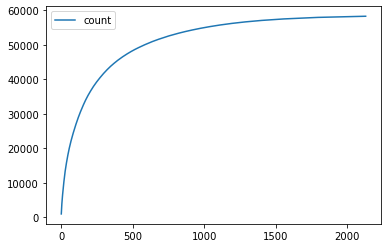

In [294]:
train.groupby(['brand', 'model', 'equipment'])['bias'].agg(['count']).sort_values('count', ascending=False)['count'].cumsum().reset_index().plot.line()

In [37]:
grouping_features = ['brand', 'model', 'equipment', 'modification']

pd.concat([dfx.groupby(grouping_features)['bias'].agg([('MAPE', lambda x: np.abs(x).median() * 100), 'count']).sort_values('count', ascending=False)[:10] for dfx in [train, val, test]], axis=1)

MAPE  count  \
brand      model       equipment  modification                                 
Chery      Tiggo 7 Pro prestige   1.5 CVT (147 л.с.)              NaN    NaN   
Ford       Kuga        trend plus 2.5 AT (150 л.с.)          4.738811  225.0   
Geely      Coolray     flagship   1.5 AMT (150 л.с.)              NaN    NaN   
Hyundai    Tucson      family     2.0 4WD AT (150 л.с.)           NaN    NaN   
Kia        Sorento     luxe       2.4 4WD AT (175 л.с.)           NaN    NaN   
           Soul        luxe       2.0 AT (150 л.с.)          4.431666  218.0   
           Sportage    luxe       2.0 4WD AT (150 л.с.)      4.237799  226.0   
                                  2.0 MPI 4WD AT (150 л.с.)       NaN    NaN   
Mazda      6           active     2.0 AT (150 л.с.)          4.929637  245.0   
           CX-5        active     2.0 AT (150 л.с.)          4.801410  213.0   
                       supreme    2.0 4WD AT (150 л.с.)           NaN    NaN   
Mitsubishi Outlander   instyle    2.0 4WD CVT (146 л.с.)     5.402603  387.0   
Nissan     Qashqai     se         2.0 4WD CVT (144 л.с.)     4.454118  239.0   
                                  2.0 CVT (144 л.с.)              NaN    NaN   
           X-Trail     le top     2.5 4WD CVT (171 л.с.)     4.346786  230.0   
Skoda      Octavia     style      1.4 TSI DSG (150 л.с.)     4.980460  210.0   
                                  1.8 TSI DSG (180 л.с.)     5.627884  250.0   

                                                                 MAPE  count  \
brand      model       equipment  modification                                 
Chery      Tiggo 7 Pro prestige   1.5 CVT (147 л.с.)         4.817369   50.0   
Ford       Kuga        trend plus 2.5 AT (150 л.с.)               NaN    NaN   
Geely      Coolray     flagship   1.5 AMT (150 л.с.)         4.698321   41.0   
Hyundai    Tucson      family     2.0 4WD AT (150 л.с.)           NaN    NaN   
Kia        Sorento     luxe       2.4 4WD AT (175 л.с.)      6.962236   43.0   
           Soul        luxe       2.0 AT (150 л.с.)               NaN    NaN   
           Sportage    luxe       2.0 4WD AT (150 л.с.)      4.989169   41.0   
                                  2.0 MPI 4WD AT (150 л.с.)  4.548523   48.0   
Mazda      6           active     2.0 AT (150 л.с.)               NaN    NaN   
           CX-5        active     2.0 AT (150 л.с.)               NaN    NaN   
                       supreme    2.0 4WD AT (150 л.с.)      5.714066   41.0   
Mitsubishi Outlander   instyle    2.0 4WD CVT (146 л.с.)     6.653038   71.0   
Nissan     Qashqai     se         2.0 4WD CVT (144 л.с.)     7.248937   61.0   
                                  2.0 CVT (144 л.с.)              NaN    NaN   
           X-Trail     le top     2.5 4WD CVT (171 л.с.)     6.176212   55.0   
Skoda      Octavia     style      1.4 TSI DSG (150 л.с.)          NaN    NaN   
                                  1.8 TSI DSG (180 л.с.)     7.308801   49.0   

                                                                  MAPE  count  
brand      model       equipment  modification                                 
Chery      Tiggo 7 Pro prestige   1.5 CVT (147 л.с.)          4.945847   51.0  
Ford       Kuga        trend plus 2.5 AT (150 л.с.)           5.250212   47.0  
Geely      Coolray     flagship   1.5 AMT (150 л.с.)               NaN    NaN  
Hyundai    Tucson      family     2.0 4WD AT (150 л.с.)       6.146183   47.0  
Kia        Sorento     luxe       2.4 4WD AT (175 л.с.)            NaN    NaN  
           Soul        luxe       2.0 AT (150 л.с.)                NaN    NaN  
           Sportage    luxe       2.0 4WD AT (150 л.с.)       4.930638   51.0  
                                  2.0 MPI 4WD AT (150 л.с.)        NaN    NaN  
Mazda      6           active     2.0 AT (150 л.с.)           5.287222   52.0  
           CX-5        active     2.0 AT (150 л.с.)                NaN    NaN  
                       supreme    2.0 4WD AT (150 л.с.)        

In [85]:
val.sale_end_date.min(), val.sale_end_date.max(), test.sale_end_date.max()

(Timestamp('2022-12-08 00:00:00'),
 Timestamp('2023-01-06 00:00:00'),
 Timestamp('2023-02-05 00:00:00'))

In [46]:
test.groupby('brand')['bias'].agg([lambda x: np.abs(x).mean() * 100, 'count']).sort_values('count', ascending=False)[:20]

,<lambda_0>,count
brand,,
Kia,9.129359,844
Hyundai,9.573224,657
Volkswagen,10.702328,655
BMW,10.160437,646
Nissan,12.435215,594
Skoda,10.291234,529
Toyota,10.394111,499
Mercedes-Benz,11.383356,423
Renault,9.876708,419


In [44]:
fixed_car = ('Mitsubishi', 'Outlander', 'instyle', '2.0 4WD CVT (146 л.с.)')
query_string = 'brand == @fixed_car[0] and model == @fixed_car[1] and equipment == @fixed_car[2] and modification == @fixed_car[3]'

In [169]:
X_train1 = train.query(query_string)[features].reset_index(drop=True)
X_val1 = val.query(query_string)[features].reset_index(drop=True)
X_test1 = test.query(query_string)[features].reset_index(drop=True)

y_train1, y_val1, y_test1 = train.query(query_string)['actual_price'], val.query(query_string)['actual_price'], test.query(query_string)['actual_price']

In [210]:
from catboost_utils import MedianAPE

In [224]:
params = dict(
    learning_rate=0.5,
    iterations=8,
    reg_lambda=0.00005,
    colsample_bylevel=1.,
    max_bin=80,
    bagging_temperature=2,
    loss_function='MAE',
    use_best_model=True,
    verbose=False,
    # eval_metric=MedianAPE(),
    grow_policy='Depthwise',
    random_seed=42
)
model1 = cb.CatBoostRegressor(
    **params,
)

eval_set1 = cb.Pool(data=X_val1, label=y_val1, cat_features=cat_features)
model1.fit(X_train1, y_train1, cat_features=cat_features, eval_set=eval_set1, plot=True)

((model1.predict(X_train1) - y_train1) / y_train1).abs().median(), ((model1.predict(X_val1) - y_val1) / y_val1).abs().median(), ((model1.predict(X_test1) - y_test1) / y_test1).abs().median()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

(0.05209677816035416, 0.07204269591141398, 0.07092009039043956)

In [216]:
((model1.predict(X_train1) - y_train1) / y_train1).abs().median(), ((model1.predict(X_val1) - y_val1) / y_val1).abs().median(), ((model1.predict(X_test1) - y_test1) / y_test1).abs().median()

(0.10814813225543925, 0.13603473227206947, 0.11256650626689141)

In [225]:
model1.predict(X_train1.iloc[10])

1821516.25

In [260]:
explainer1 = shap.KernelExplainer(model1.predict, X_train1)
explanation_train1 = explainer1.shap_values(X_train1.iloc[250], gc_collect=True)

Using 387 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [234]:
X_train1.brand_model_generation_restyling.value_counts()

Mitsubishi Outlander III 3    153
Mitsubishi Outlander III 2    140
Mitsubishi Outlander III 0     68
Mitsubishi Outlander III 1     26
Name: brand_model_generation_restyling, dtype: int64

In [259]:
X_train1.iloc[250]

brand_model_generation_restyling    Mitsubishi Outlander III 2
brand                                               Mitsubishi
model                                                Outlander
generation                                                 III
modification                            2.0 4WD CVT (146 л.с.)
equipment                                              instyle
restyling                                                    2
engine_volume                                              2.0
generation_years                                   (2015—2018)
body_type                                          Внедорожник
drive_type                                              Полный
transmission_type                                     Вариатор
engine_type                                             Бензин
color                                                    Белый
owners_count                                                 1
steering_wheel                                         

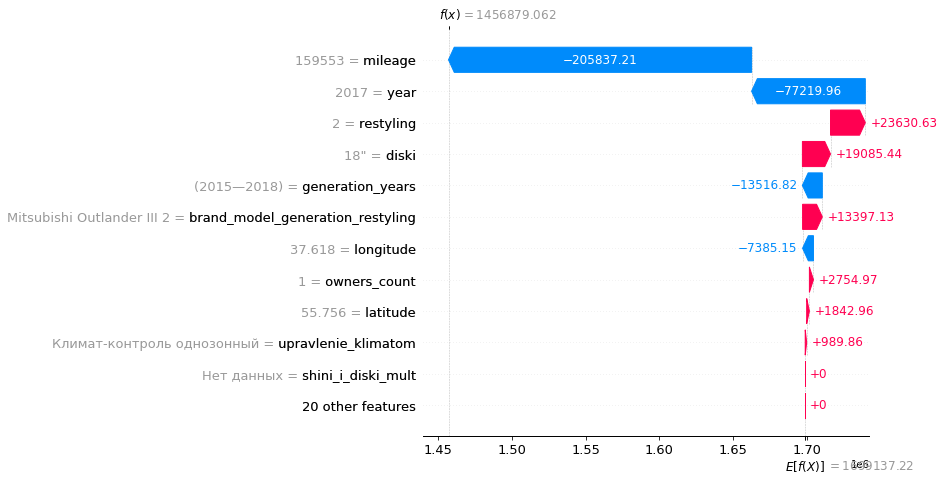

In [261]:
expl1 = shap.Explanation(explanation_train1, explainer1.expected_value, X_train1.iloc[250])
shap.waterfall_plot(expl1, max_display=12)

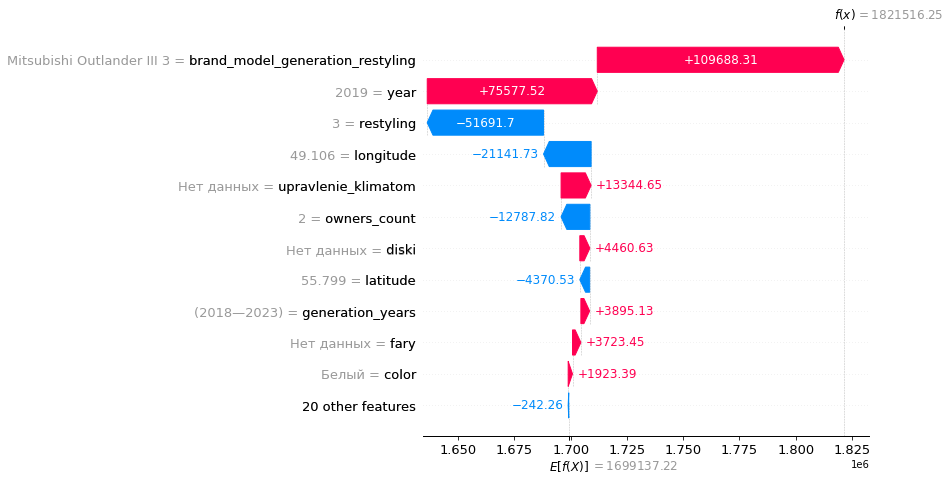

In [251]:
expl1 = shap.Explanation(explanation_train1, explainer1.expected_value, X_train1.iloc[250])
shap.waterfall_plot(expl1, max_display=12)

In [236]:
X_train1.groupby('brand_model_generation_restyling')[['year']].agg(['mean', 'median', 'min', 'max', 'var'])

year                              
                                         mean  median   min   max       var
brand_model_generation_restyling                                           
Mitsubishi Outlander III 0        2012.705882  2013.0  2012  2014  0.509219
Mitsubishi Outlander III 1        2014.153846  2014.0  2014  2015  0.135385
Mitsubishi Outlander III 2        2016.500000  2016.0  2015  2018  0.985612
Mitsubishi Outlander III 3        2019.620915  2019.0  2018  2022  1.355349

0.07015227006325916

In [39]:
X_train.shape, X_val.shape, X_test.shape

((58301, 31), (11508, 31), (11617, 31))

In [50]:
X_train_fixed = X_train.query(query_string)
X_val_fixed = X_val.query(query_string)
X_test_fixed = X_test.query(query_string)

In [51]:
import shap
shap.initjs()

In [53]:
model

In [71]:
explainer = shap.KernelExplainer(model.predict, X_train_fixed)
explanation_train = explainer.shap_values(X_train_fixed, gc_collect=True)
explanation_val = explainer.shap_values(X_val_fixed)
explanation_test = explainer.shap_values(X_test_fixed)

Using 387 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

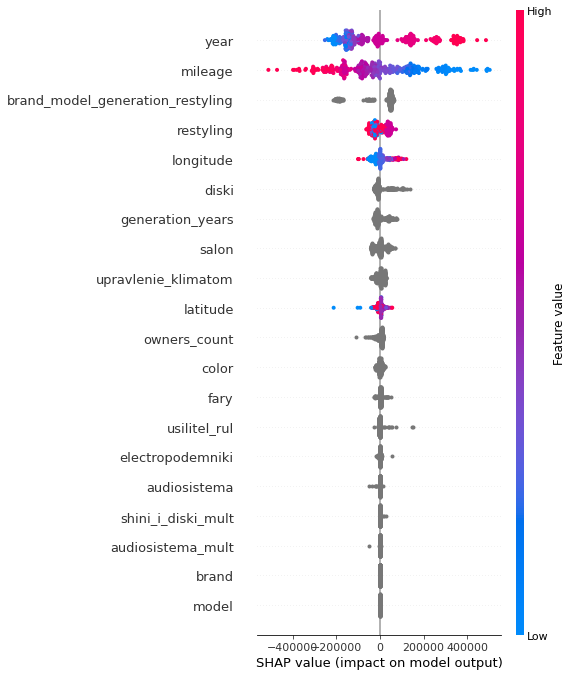

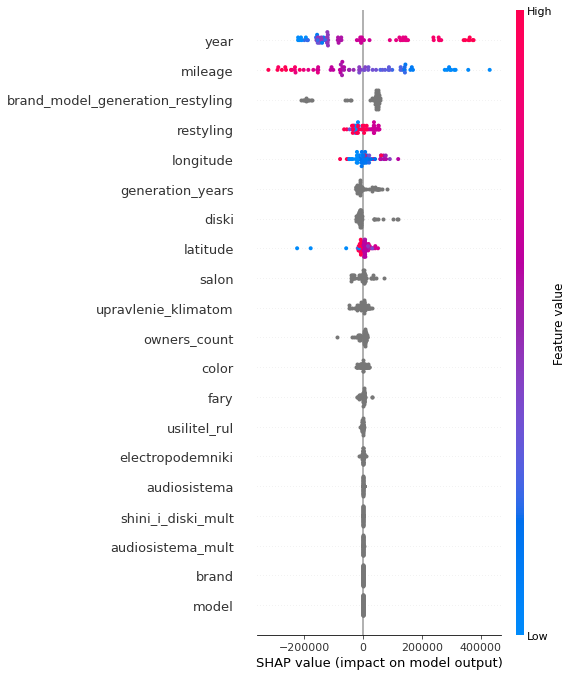

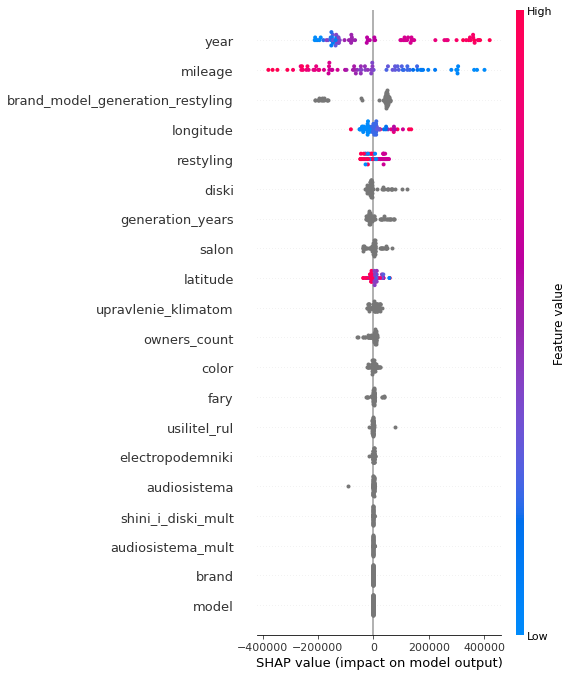

In [81]:
shap.summary_plot(explanation_train, X_train_fixed)
shap.summary_plot(explanation_val, X_val_fixed)
shap.summary_plot(explanation_test, X_test_fixed)

In [240]:
all_shap = shap.Explanation(values=explanation_train, data=X_train_fixed.values, feature_names=X_train_fixed.columns)

In [243]:
shap.plots.scatter(all_shap[:, 'brand_model_generation_restyling'], color=all_shap[:, "restyling"])

TypeError: unsupported operand type(s) for -: 'str' and 'str'

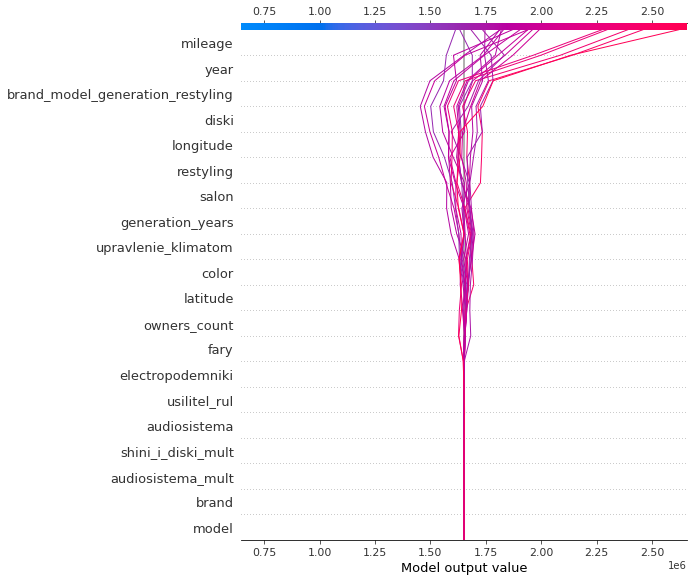

In [249]:
shap.decision_plot(explainer.expected_value, all_shap.values[:20], X_train_fixed[:20])

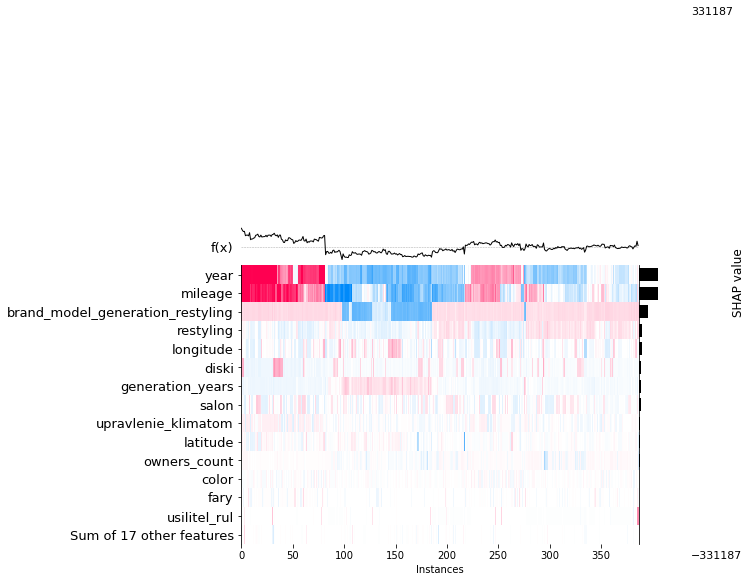

In [244]:
shap.plots.heatmap(all_shap, max_display=15)

In [87]:
explainer.expected_value

1652034.94457275

In [62]:
train['actual_price'].mean()

1624975.0029023509

In [96]:
train.head(1)['year']

3    2018
Name: year, dtype: int64

In [91]:
shap.force_plot(explainer.expected_value, explanation_train[0])

In [94]:
explanation_train.shape

(387, 31)

In [105]:
(X_train.equipment).value_counts()[:40]

базовая         6538
comfort         4162
luxe            2831
active          2390
style           2369
base            1967
elegance        1523
se              1393
sport           1377
prestige        1132
cosmo            973
highline         963
особая серия     924
instyle          916
ambition         834
m sport          818
titanium         810
premium          796
life             704
luxury           691
comfortline      671
privilege        635
trend plus       601
classic          556
executive        544
business         531
comfort plus     523
supreme          485
drive            481
trendline        462
family           438
trend&fun        429
exclusive        419
m sport pro      414
elite            409
trend            384
le top           371
комфорт          332
high-tech        302
lt               292
Name: equipment, dtype: int64

equipment связать с доп. опциями

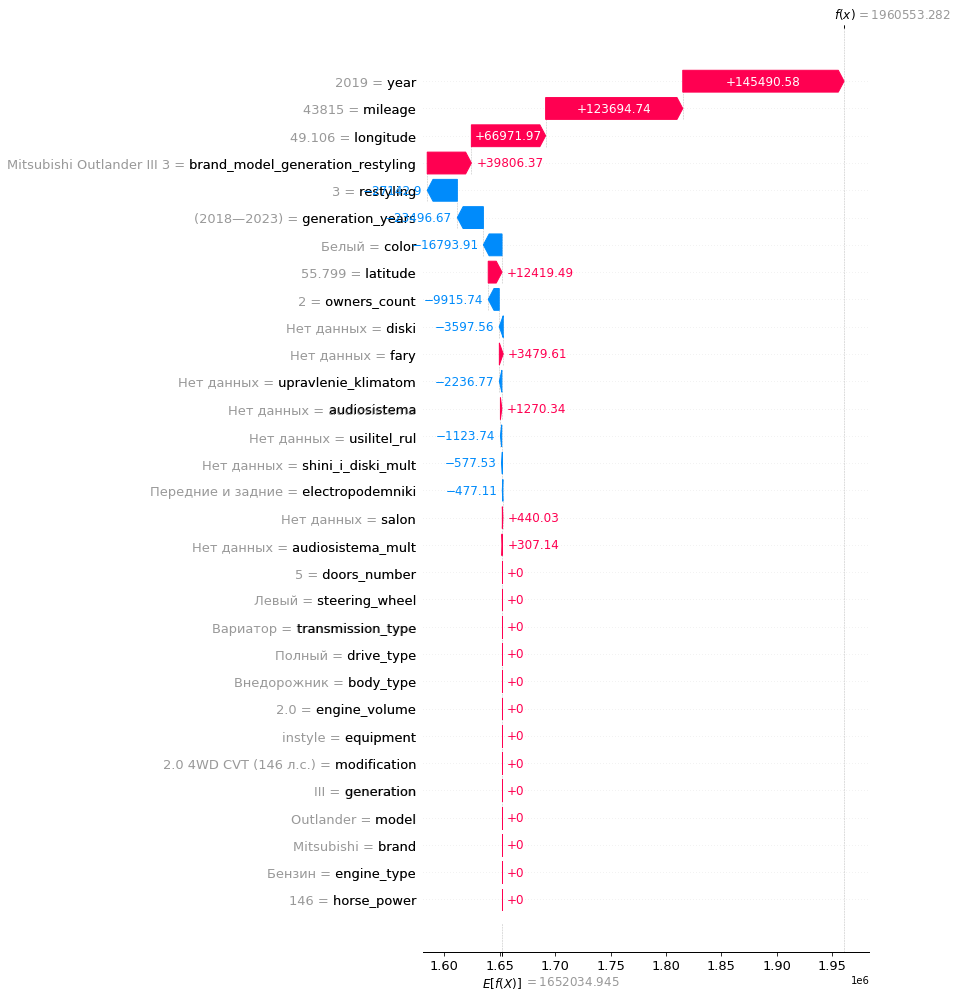

In [232]:
idx = 10
expl = shap.Explanation(explanation_train[idx], explainer.expected_value, X_train_fixed.iloc[idx])
shap.waterfall_plot(expl, max_display=40)

In [179]:
train.query(query_string).iloc[10]

actual_price                                                                1769000.0
price                                                         1799000.000000000000000
sale_end_date                                                     2022-11-16 00:00:00
description                         Более 1000 автомобилей с пробегом на сайте КАН...
brand                                                                      Mitsubishi
                                                          ...                        
engine_volume                                                                     2.0
horse_power                                                                       146
brand_model_generation_restyling                           Mitsubishi Outlander III 3
prediction                                                             1960553.282495
bias                                                                        -0.108283
Name: 934, Length: 66, dtype: object

In [264]:
X_train1.brand_model_generation_restyling.value_counts()

Mitsubishi Outlander III 3    153
Mitsubishi Outlander III 2    140
Mitsubishi Outlander III 0     68
Mitsubishi Outlander III 1     26
Name: brand_model_generation_restyling, dtype: int64

In [263]:
my_sample = X_train_fixed.iloc[10].copy()

for i in range(4):
    for j in range(2020, 2014, -1):
        my_sample['restyling'] = i
        my_sample['brand_model_generation_restyling'] = f'Mitsubishi Outlander III {i}'
        my_sample['year'] = j
        print(i, j, model1.predict(my_sample))
    print()

0 2020 1763478.9375
0 2019 1640717.4375
0 2018 1640717.4375
0 2017 1435717.4375
0 2016 1435717.4375
0 2015 1435717.4375

1 2020 1763478.9375
1 2019 1640717.4375
1 2018 1640717.4375
1 2017 1435717.4375
1 2016 1435717.4375
1 2015 1435717.4375

2 2020 1956602.6875
2 2019 1833841.1875
2 2018 1833841.1875
2 2017 1753735.6875
2 2016 1753735.6875
2 2015 1753735.6875

3 2020 2006610.25
3 2019 1821516.25
3 2018 1857121.75
3 2017 1585121.75
3 2016 1585121.75
3 2015 1585121.75



In [ ]:
X_train_fixed

In [124]:
test.groupby('restyling')[['actual_price', 'year']].agg(['mean', 'median', 'min', 'max', 'var'])

actual_price                                                 \
                   mean     median       min         max           var   
restyling                                                                
0          1.691047e+06  1400000.0   27000.0  21599000.0  1.901553e+12   
1          1.473239e+06  1232881.0   91000.0  15300000.0  1.140613e+12   
2          2.769554e+06  1841000.0  129000.0  12200000.0  5.050670e+12   
3          1.945730e+06  1948000.0  799000.0   3150000.0  2.531302e+11   

                  year                                 
                  mean  median   min   max        var  
restyling                                              
0          2015.295665  2016.0  1989  2022  19.443427  
1          2015.398372  2016.0  1998  2022  16.746913  
2          2016.572519  2017.0  2006  2021   9.903529  
3          2019.755906  2019.0  2018  2022   1.312961

In [141]:
train.query(query_string).groupby('restyling')[['actual_price', 'year']].agg(['mean', 'median', 'min', 'max', 'var'])

actual_price                                                 \
                   mean     median        min        max           var   
restyling                                                                
0          1.111794e+06  1124000.0   788700.0  1490000.0  2.308505e+10   
1          1.328660e+06  1308000.0  1108910.0  1675000.0  1.741977e+10   
2          1.576175e+06  1572000.0  1127000.0  2028000.0  3.185218e+10   
3          2.131525e+06  2108500.0  1325000.0  2950000.0  1.183207e+11   

                  year                                
                  mean  median   min   max       var  
restyling                                             
0          2012.705882  2013.0  2012  2014  0.509219  
1          2014.153846  2014.0  2014  2015  0.135385  
2          2016.500000  2016.0  2015  2018  0.985612  
3          2019.620915  2019.0  2018  2022  1.355349

In [147]:
test.query(query_string).groupby('restyling')[['actual_price', 'year']].agg(['mean', 'median', 'min', 'max', 'var'])

actual_price                                                 \
                   mean     median        min        max           var   
restyling                                                                
0          1.144589e+06  1150000.0   870000.0  1517000.0  3.349903e+10   
1          1.342000e+06  1342000.0  1144000.0  1540000.0  7.840800e+10   
2          1.639426e+06  1615000.0  1392000.0  1944638.0  2.129904e+10   
3          2.227418e+06  2190500.0  1612789.0  3000000.0  1.301104e+11   

                 year                                
                 mean  median   min   max       var  
restyling                                            
0          2012.80000  2013.0  2012  2014  0.457143  
1          2014.00000  2014.0  2014  2014  0.000000  
2          2016.56000  2017.0  2015  2018  1.006667  
3          2020.09375  2020.0  2018  2022  1.571573

In [108]:
X_train_fixed.restyling.value_counts()

3    153
2    140
0     68
1     26
Name: restyling, dtype: int64

In [92]:
model.predict(X_train_fixed.iloc[0])

2390878.5373289026

In [64]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def show_waterfall_for_one(id=0):
    # print(explanation.data[id])
    shap.waterfall_plot(explanation_train[id], max_display=20)

interact(show_waterfall_for_one, id=list(range(100)));

interactive(children=(Dropdown(description='id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

In [63]:
train.iloc[1]['latitude']

47.222543

In [86]:
new_check_df = pd.DataFrame([X_train.iloc[1].copy() for _ in range(50000)])

In [87]:
new_check_df['latitude'] = X_train['latitude'].sample(50000).values
new_check_df['longitude'] = X_train['longitude'].sample(50000).values

In [80]:
model.predict(X_train.iloc[1])

1495859.266757317

In [88]:
pd.DataFrame(model.predict(new_check_df)).describe().style.format({'0': '{:.4f}'})

,0
count,50000.000000
mean,1464047.666004
std,32397.103453
min,1315832.610963
25%,1438532.100935
50%,1456557.481910
75%,1491192.787671
max,1616715.889428


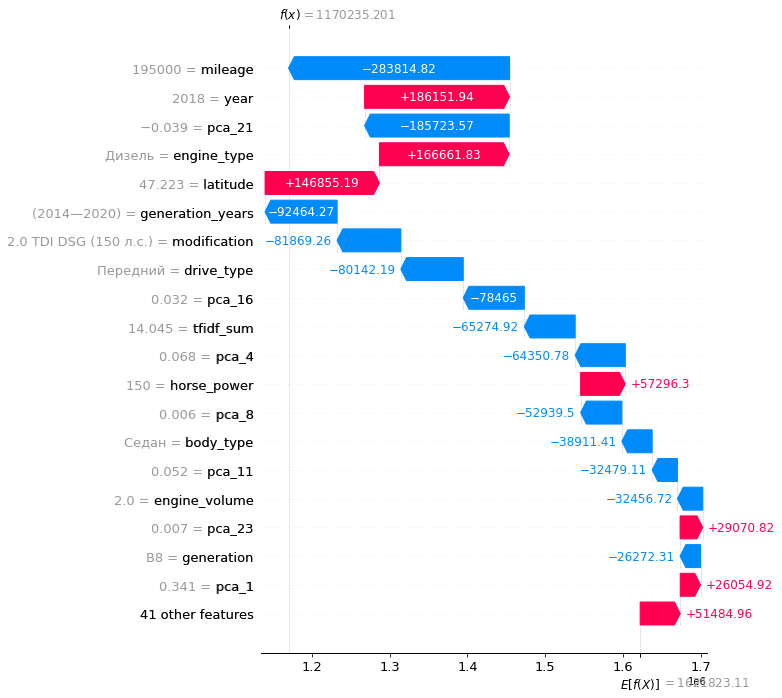

In [48]:
shap.waterfall_plot(explanation[1], max_display=20)